# Pythonによる画像解析ノート Vol. 2

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

## 画像の基本統計量
画像全体のピクセルベースの統計量（平均値、最大値等）を計算する。様々な方法があるが、`scipy.stats.describe()`が便利。

In [41]:
# 要約統計量
# cv2.calcHistについて


In [42]:
from tifffile import tifffile as tiff
img = tiff.imread("images/cell_16bit.tif")
print("読み込まれた画像の枚数:", len(img))
print("配列の次元数:", img.ndim)
print("配列の形状:", img.shape)
print("要素のデータ型:", img.dtype)

読み込まれた画像の枚数: 292
配列の次元数: 2
配列の形状: (292, 333)
要素のデータ型: uint16


<class 'numpy.ndarray'>
(27644,)


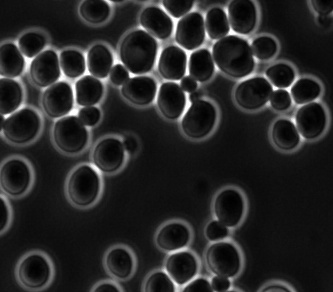

In [43]:
show(img)

In [44]:
# Numpy arrayの基本的なメソッドである程度計算できる。
print("平均値:", img.mean())
print("最大値:", img.max())
print("最小値:", img.min())
print("分散:", img.var())
print("標準偏差:", img.std())

平均値: 3555.753794890781
最大値: 16383
最小値: 1162
分散: 6038955.796431874
標準偏差: 2457.4286961032813


In [45]:
# scipy.stats.describe()でまとめて計算。2次元配列を1次元配列に直す必要がある。
from scipy import stats
stats.describe(img.reshape(-1))

DescribeResult(nobs=97236, minmax=(1162, 16383), mean=3555.753794890781, variance=6039017.90324317, skewness=2.3802287974002234, kurtosis=6.514954322845737)

## 画像のヒストグラム  

(0.0, 20000.0)

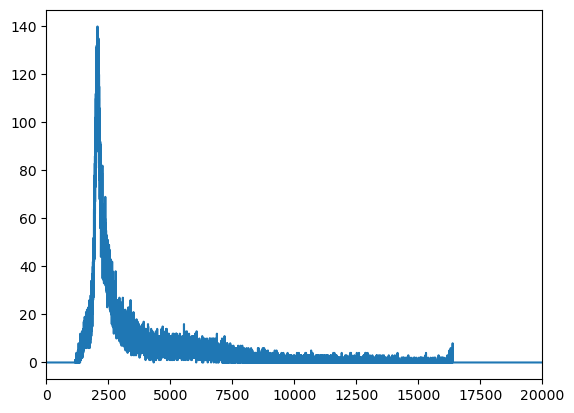

In [46]:
# OpenCVのcalcHist()関数を使って出現頻度を計算
# cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
# imgのピクセル値のデータ型はuint8かfloat32
img = img.astype("float32") # float32に変換
hist = cv2.calcHist([img], [0], None, [65536], [0.0, 65536.0]) # カラー画像の場合、channels = 0 or 1 or 2
plt.plot(hist)
plt.xlim([0,20000])

(array([    0., 14647., 46537., 10902.,  6483.,  5631.,  4605.,  2727.,
         1477.,   987.,   739.,   603.,   570.,   449.,   291.,   244.,
          344.,     0.,     0.,     0.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
        16000., 17000., 18000., 19000., 20000.]),
 <BarContainer object of 20 artists>)

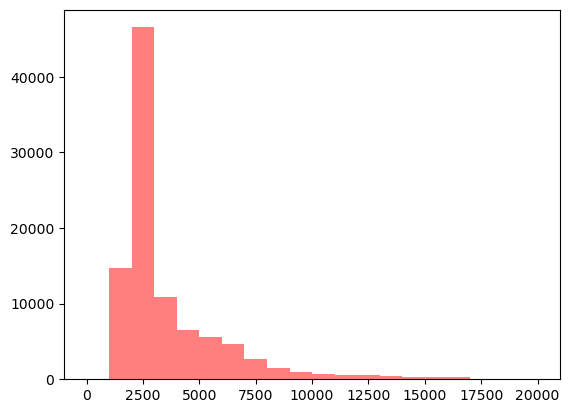

In [47]:
# Matplotlibのhist関数を使えば、出現頻度を計算する必要が無い
plt.hist(img.ravel(), bins = 20, range = [0, 20000], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

(512, 512, 3)


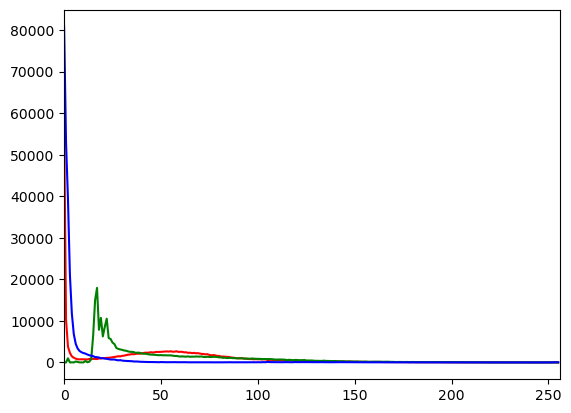

In [48]:
# 8-bit, RGB画像の場合
fcell = tiff.imread("images/FluorescentCells.tif") # tiff.imread()では(R, G, B)として読み込まれる
print(fcell.shape)
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv2.calcHist([fcell],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

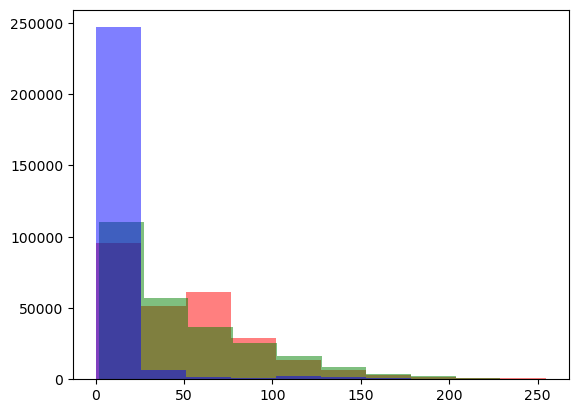

In [49]:
# 8-bit, RGB画像でMatplotlib.hist()を使用する場合
fcell = tiff.imread("images/FluorescentCells.tif")
color = ('r','g','b')
for i,col in enumerate(color):
    plt.hist(fcell[:, :, i].ravel(), color= col, alpha = 0.5) # ravel()で1次元配列に戻す

### ヒストグラム平坦化  
ヒストグラムの平坦化により、画像のコントラストが向上する。領域の分節化に有効。  
数値を変更してしまうので、ピクセル値を定量する場合は複製しておく。

<class 'numpy.ndarray'>
(35744,)


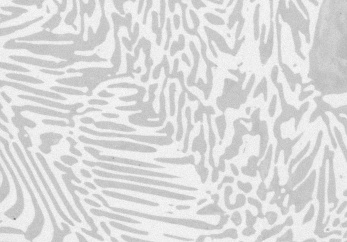

<class 'numpy.ndarray'>
(70047,)


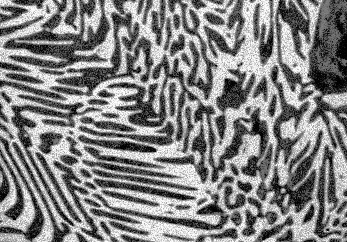

In [50]:
alloy = cv2.imread("images/Alloy.jpg", 0)
alloy =cv2.resize(alloy, (alloy.shape[1] // 2, alloy.shape[0] // 2)) # 0.5倍に縮小
eq_alloy = cv2.equalizeHist(alloy)
show(alloy)
show(eq_alloy)

適用的ヒストグラム平坦化  
CLAHE (Contrast Limited Adaptive Histogram Equalization)  
画像を “タイル(tiles)” (OpenCVのデフォルトでは8x8)と呼ばれる小領域に分割し，領域毎にヒストグラム平坦化を適用。

<class 'numpy.ndarray'>
(51519,)


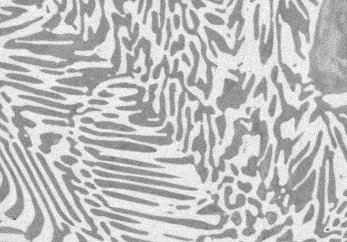

In [51]:
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
cl_alloy = clahe.apply(alloy)
show(cl_alloy)

scikit-imageを使用する場合

<class 'numpy.ndarray'>
(70047,)


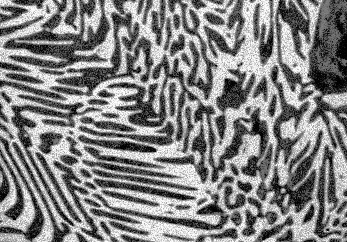

In [52]:
from skimage import exposure
eq_alloy2 = exposure.equalize_hist(alloy)
show(eq_alloy2*255)

<class 'numpy.ndarray'>
(56424,)


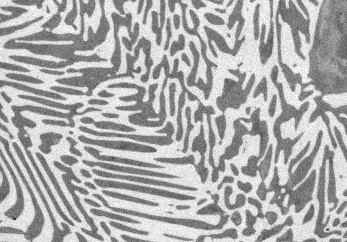

In [53]:
# 適用的ヒストグラム平坦化
clahe2 = exposure.equalize_adapthist(alloy)
show(clahe2*255)

### コントラストストレッチ  
画像のピクセル値を線形変換。`skimage.exposure.rescale_intensity()`関数を使用。  
デフォルトではピクセル値の最小値と最大値をそれぞれ、階調の最小値と最大値に引き伸ばす。  

<class 'numpy.ndarray'>
(48521,)


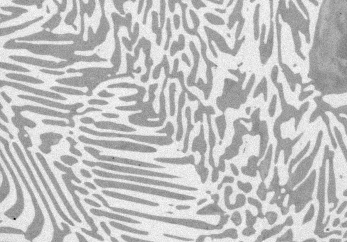

In [54]:
from skimage import exposure
alloy = cv2.imread("images/Alloy.jpg", 0)
alloy =cv2.resize(alloy, (alloy.shape[1] // 2, alloy.shape[0] // 2)) # 0.5倍に縮小
alloy_rescale = exposure.rescale_intensity(alloy)
show(alloy_rescale)

<class 'numpy.ndarray'>
(68740,)


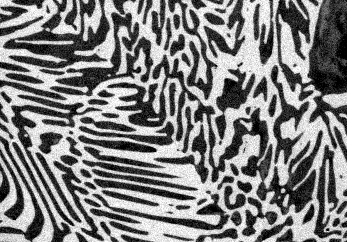

In [55]:
# 2%と98%分位点をそれぞれ最小、最大値に割り当てる場合、ImageJ/FIJIのAdjust Contrast -> Autoに近い。
p2, p98 = np.percentile(alloy, (2, 98))
alloy_rescale2 = exposure.rescale_intensity(alloy, in_range=(p2, p98))
show(alloy_rescale2)

<class 'numpy.ndarray'>
(31175,)


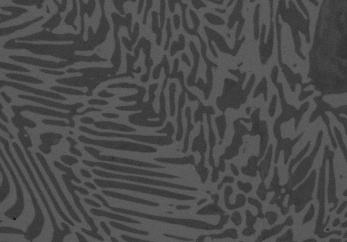

In [57]:
# 逆に出力画像のピクセル値の範囲を指定することもできる
alloy_rescale3 = exposure.rescale_intensity(alloy, out_range=(0, 100))
show(alloy_rescale3)

## 背景除去
rolling-ball background subtraction  
専用のパッケージ opencv-rolling-ballを使用する  
ImageJのBackground Subtractionと同等の機能、ただし8bit画像である必要があるので、  
16bit画像の場合は`skimage.util.img_as_ubyte()`で8bitに変換

<class 'numpy.ndarray'>
(22213,)


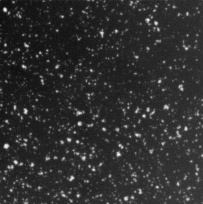

<class 'numpy.ndarray'>
(13963,)


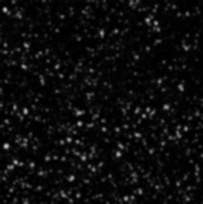

<class 'numpy.ndarray'>
(2756,)


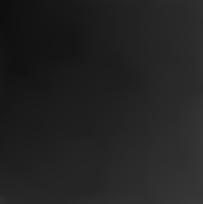

In [2]:
from cv2_rolling_ball import subtract_background_rolling_ball
img = cv2.imread("images/Cell_Colony.tif", 0)
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2)) # 0.5倍に縮小
img = ~img # pixel値が反転する
show(img)
# 入力画像のimgも変更される
radius = 50
img_bg, background = subtract_background_rolling_ball(img, radius, light_background=False,
                                     use_paraboloid=False, do_presmooth=True)
show(img_bg)
show(background)

scikit-imageのパッケージを使う場合  
計算されたbackgroundの画像が返ってくるので、元の画像から差し引く

<class 'numpy.ndarray'>
(22213,)


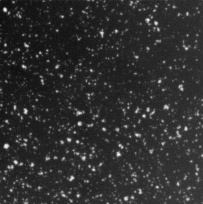

<class 'numpy.ndarray'>
(22209,)


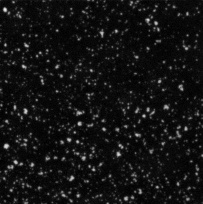

<class 'numpy.ndarray'>
(2723,)


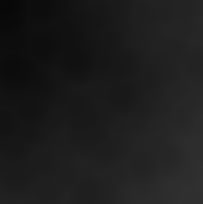

In [19]:
from skimage import restoration
img = cv2.imread("images/Cell_Colony.tif", 0)
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2)) # 0.5倍に縮小
img = ~img # pixel値が反転する
background = restoration.rolling_ball(img, radius = 50, kernel=None,
                                     nansafe=False, num_threads=None)
filtered = img - background
show(img)
show(filtered)
show(background)

#### 処理速度を比較  
同じ画像を縮小せずに処理、scikit-imageの方が8-9倍速い

In [32]:
%%timeit -r 10 -n 3
img = cv2.imread("images/Cell_Colony.tif", 0)
img = ~img # pixel値が反転する
# 入力画像のimgも変更される
radius = 50
img_bg, background1 = subtract_background_rolling_ball(img, radius, light_background=False,
                                     use_paraboloid=False, do_presmooth=False)

1.74 s ± 48.9 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [33]:
%%timeit -r 10 -n 3
img2 = cv2.imread("images/Cell_Colony.tif", 0)
img2 = ~img2 # pixel値が反転する
radius = 50
background2 = restoration.rolling_ball(img2, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)
filtered = img2 - background2

205 ms ± 8.91 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [34]:
# 画像の比較、ほとんど差は無い
from skimage.util import compare_images
from skimage import io, img_as_float, img_as_ubyte
diff_compared = img_as_ubyte(compare_images(img_bg, filtered, method='diff'))

dtype('uint8')

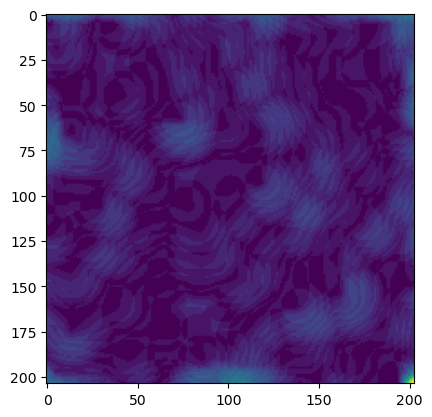

In [39]:
plt.imshow(diff_compared)
# show(diff_compared*10)
diff_compared.dtype

フルサイズの顕微鏡画像（1636x1088 pixels）で処理速度を比較  

skimageの場合：  
130 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)   

opencvの場合：  
3min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)  

opencvの処理時間が極端に長くなり、skimageの1700倍になっている

In [2]:
from skimage import restoration
from cv2_rolling_ball import subtract_background_rolling_ball

In [4]:
%%timeit -r 1 -n 3
img2 = cv2.imread("images/for_batch_processing/dots_image_1.tif", 0)
radius = 10
background2 = restoration.rolling_ball(img2, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)

130 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [5]:
%%timeit -r 1 -n 3
img = cv2.imread("images/for_batch_processing/dots_image_1.tif", 0)
# 入力画像のimgも変更される
radius = 10
img_bg, background1 = subtract_background_rolling_ball(img, radius, light_background=False,
                                     use_paraboloid=False, do_presmooth=False)

3min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


### ImageJ/FIJIにおけるrolling-ball background subtractionとの違い  
上記cv2とskimageのrolling-ball background subtractionによる処理結果は、ImageJ/FIJIにおける処理と同一にはならない。  
比較した所、cv2による処理の方が、ImageJ/FIJIにおける処理との誤差が小さかった。

In [4]:
from skimage import restoration
from skimage.morphology import square, disk, ball
from skimage.filters import rank

In [9]:
# skimageのmethod
img = cv2.imread("images/dots_large.tif", 0)
radius = 10
background = restoration.rolling_ball(img, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)
filtered = img - background 
cv2.imwrite("images/filtered.tif", filtered)

True

In [8]:
# cv2のmethod
img = cv2.imread("images/dots_large.tif", 0)
radius = 10
filtered, background1 = subtract_background_rolling_ball(img, radius, light_background=False,
                                     use_paraboloid=False, do_presmooth=False)
cv2.imwrite("images/filtered.tif", filtered)

True

## 画像のフィルタ処理
顕微鏡画像を分節化する前処理。様々なフィルタで処理することで、ノイズを除去したり、特徴を抽出する。

#### ガウシアンフィルタ
ホワイトノイズの除去に適している

<class 'numpy.ndarray'>
(38924,)


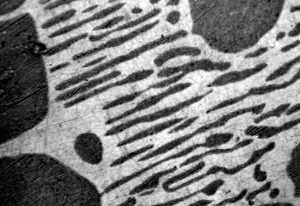

In [3]:
aupb = cv2.imread("images/AuPbSn40.tif", 0)
aupb =cv2.resize(aupb, (aupb.shape[1] // 2, aupb.shape[0] // 2)) # 0.5倍に縮小
show(aupb)

<class 'numpy.ndarray'>
(21554,)


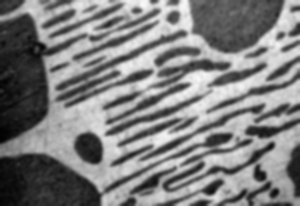

<class 'numpy.ndarray'>
(24657,)


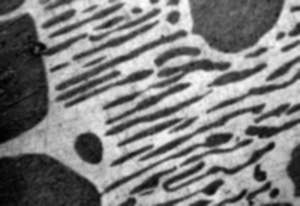

In [16]:
gblur1 = cv2.GaussianBlur(
    aupb,    # 入力画像
    (7, 7), # カーネルのサイズ(幅、高さ)
    1.4,    # X方向のσの値(-1など負の値を指定するとカーネルサイズから自動計算)
    0,      # Y方向のσの値(0だとX方向と同じ)
    borderType = cv2.BORDER_DEFAULT  # ボーダー処理の種類
    )
# ガウシアンフィルタ（カーネルサイズを自動計算）
gblur2 = cv2.GaussianBlur(
    aupb,    # 入力画像
    (0, 0), # カーネルのサイズを０にしてσの値からカーネルサイズを自動計算
    1       # X方向のσの値, Y方向のσを指定しないとXと同じ値になる
    )
show(gblur1)
show(gblur2)

<class 'numpy.ndarray'>
(31687,)


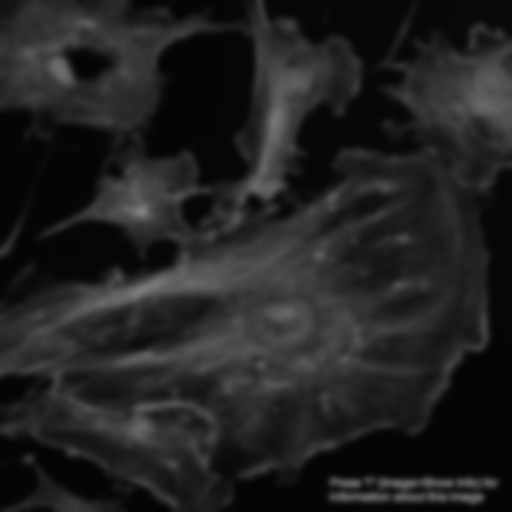

In [17]:
# scipy.ndimageを使う場合
from scipy import ndimage as nd
fl = cv2.imread("images/FluorescentCells.tif")
gfl = nd.gaussian_filter(fl, sigma = 3)
show(gfl)

#### 平均化フィルタ

<class 'numpy.ndarray'>
(21239,)


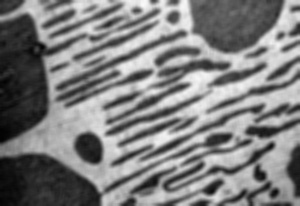

In [11]:
blur = cv2.blur(aupb,(5,5))
show(blur)

<class 'numpy.ndarray'>
(21331,)


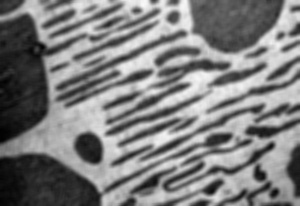

In [12]:
# skimageを使用する場合
from skimage.morphology import square, disk, ball
from skimage.filters import rank
blur2 = rank.mean(aupb, square(5)) # カーネルのサイズではなく、カーネルそのもの（要素が全て1の5x5の行列）
show(blur2)

<class 'numpy.ndarray'>
(8558,)


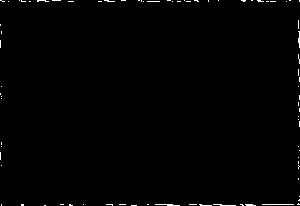

In [17]:
blur_diff = blur - blur2
show(blur_diff)

#### 中央値フィルタ
ごま塩ノイズのような特異なノイズに対して効果的

<class 'numpy.ndarray'>
(29707,)


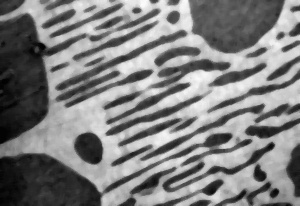

In [19]:
median = cv2.medianBlur(aupb,5)
show(median)

<class 'numpy.ndarray'>
(29657,)


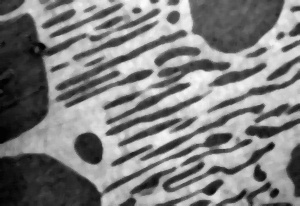

In [20]:
# scipyを使う場合
median2 = nd.median_filter(aupb, size = 5)
show(median2)

#### バイラテラルフィルタ
エッジを保存しながら画像をぼかすことができる

<class 'numpy.ndarray'>
(27777,)


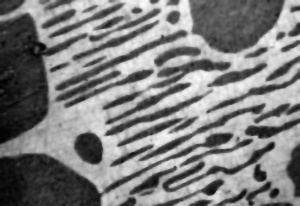

In [21]:
bl = cv2.bilateralFilter(aupb,5,75,75)
show(bl)

#### Non-local means filtering (NLM)
バイラテラルフィルターよりも優れているらしいが、計算量が多い

<class 'numpy.ndarray'>
(48061,)


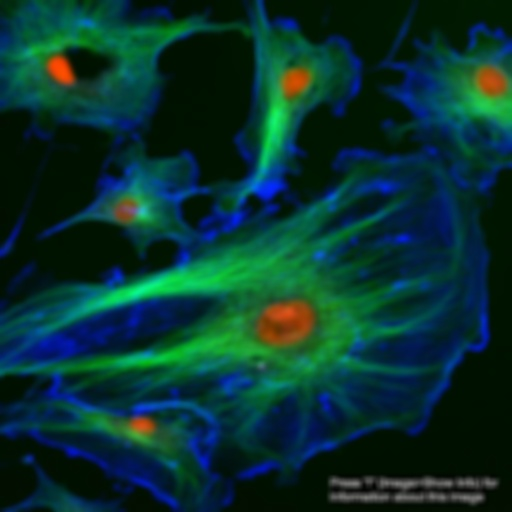

In [22]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import io, img_as_float
sigma_est = np.mean(estimate_sigma(aupb, channel_axis=-1))
img = img_as_float(io.imread("images/FluorescentCells.tif"))
# patch_kw = dict(patch_size=5,      
#                 patch_distance=3,  
#                 multichannel=True)

nlm = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False,
                               patch_size=5, patch_distance=3, channel_axis=-1)
"""
denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False,
                           **patch_kw)
"""
show(nlm*255)

#### エントロピーフィルター
コントラストが低く、しきい値で分割するのが困難な画像に対して使用。Noisyな領域とそうでない領域をわけるのに有効。  
エントロピーが高い領域は値が高くなる。

<class 'numpy.ndarray'>
(23767,)


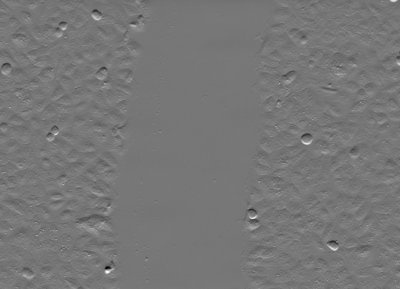

<class 'numpy.ndarray'>
(51121,)


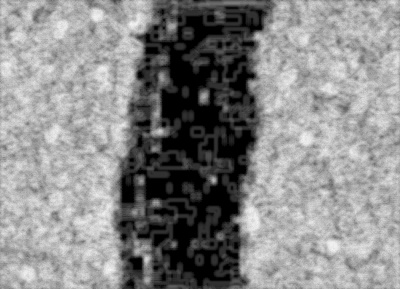

In [23]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
scr = cv2.imread("images/Scratch0.jpg", 0)
entr_scr = entropy(scr, disk(3))
show(scr)
show(entr_scr*50) # 適当に画像を明るくしている

## 画像の2値化
グレースケール画像に対して、閾値を設定して白黒画像にする

<class 'numpy.ndarray'>
(1332,)


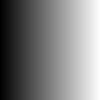

In [20]:
ramp = cv2.imread("images/ramp_rgb.tif", cv2.IMREAD_GRAYSCALE) # グレイスケールで読み込む
show(ramp)

<class 'numpy.ndarray'>
(512,)


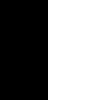

<class 'numpy.ndarray'>
(512,)


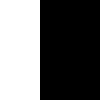

In [21]:
# retは閾値, threshは2値化画像
# 第1引数は入力画像、第2引数は閾値、ピクセル値がこの値より大きければ、第3引数の最大値（ここでは255 = 白）に割り当て、それ以下ならば0 = 黒にする
# 第4引数は閾値処理のフラグ、THRESH_BINARY_INVにすると処理が白黒逆になる
ret, ramp_bin = cv2.threshold(ramp, 120, 255, cv2.THRESH_BINARY)
ret, ramp_bin_inv = cv2.threshold(ramp, 100, 255, cv2.THRESH_BINARY_INV)
show(ramp_bin)
show(ramp_bin_inv)

#### 大津の手法による2値化

<class 'numpy.ndarray'>
(38924,)


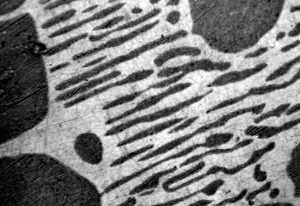

124.0
<class 'numpy.ndarray'>
(45300,)


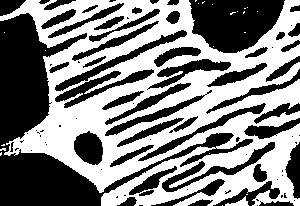

In [24]:
# 第2引数は0にしておく、フラグに + でcv2.THRESH_OTSUを追加して使用する
# retに計算された閾値が返ってくる
# aupb = cv2.imread("images/AuPbSn40.tif", 0)
ret, aupb_bin = cv2.threshold(aupb, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show(aupb)
print(ret)
show(aupb_bin)

#### 様々な2値化のアルゴリズム  
大津の手法以外にも様々な画像2値化の手法が存在する。  `skimge.filters`にはそれらを一度に試す関数があり、最適な手法を選択する目安になる。

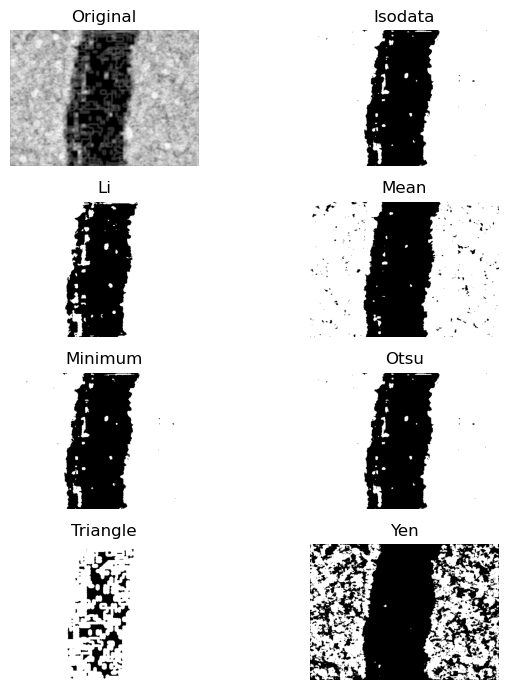

In [26]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(entr_scr, figsize =(7, 7), verbose = False)
plt.show()

<class 'numpy.ndarray'>
(12310,)


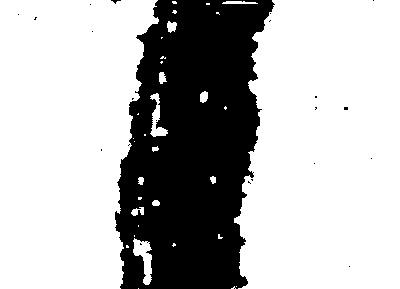

In [36]:
# Otsu filterが最適、skimageでもOtsu thresholdを計算できある
from skimage.filters import threshold_otsu
thresh = threshold_otsu(entr_scr)
bin_scr = np.where(entr_scr > thresh, 1, 0) # numpyによる2値化処理
show(bin_scr*255)

## Histogram-based multi segmentation  
大津の手法はヒストグラムを解析して2つの領域に分けるが、マニュアルで複数の領域に分けることができる  
https://www.youtube.com/watch?v=kIVk0IhDMwY

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage import data, img_as_float, img_as_ubyte
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

<class 'numpy.ndarray'>
(100510,)


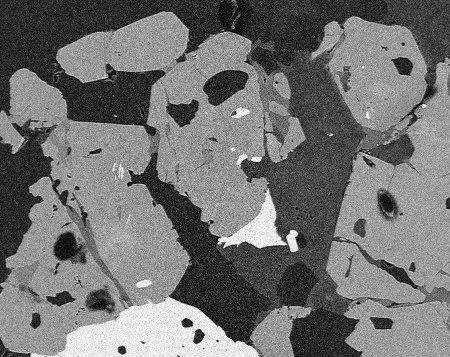

<class 'numpy.ndarray'>
(71885,)


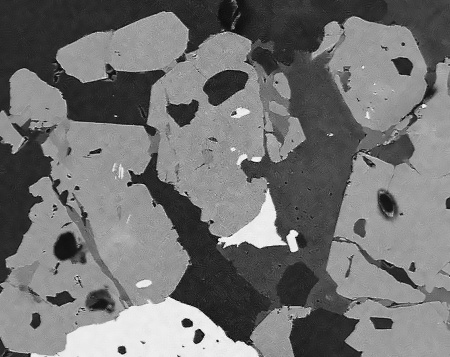

In [27]:
"""
まず非局所平均フィルターでノイズを除く、各領域のテクスチャの情報は失われる傾向にある
estimate_sigmaにより、ノイズの乗った画像のノイズのsigma値を推測することができる
"""
img = img_as_float(io.imread("images/BSE_Google_noisy.jpg")) 
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2)) # 0.5倍に縮小
sigma_est = np.mean(estimate_sigma(img, channel_axis= None)) # grayscaleの場合はNone
denoise = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False,
                           patch_size=5, patch_distance=3, channel_axis=None) # grayscaleの場合はNone
show(img*255)
show(denoise*255)

(array([0.0000e+00, 3.0000e+00, 5.0000e+00, 2.2000e+01, 2.9000e+01,
        7.1000e+01, 1.5600e+02, 5.9600e+02, 4.9400e+02, 5.3800e+02,
        5.8600e+02, 6.0700e+02, 1.8500e+03, 2.3770e+03, 6.9210e+03,
        6.9820e+03, 9.5040e+03, 4.0710e+03, 3.1850e+03, 1.2230e+03,
        1.2350e+03, 1.2430e+03, 9.7400e+02, 2.1720e+03, 1.9360e+03,
        3.3680e+03, 2.3450e+03, 3.4170e+03, 2.0190e+03, 2.4000e+03,
        1.5410e+03, 7.1000e+02, 7.5300e+02, 3.3900e+02, 4.3800e+02,
        2.7600e+02, 3.8000e+02, 2.6800e+02, 4.7500e+02, 3.5200e+02,
        6.5700e+02, 7.4300e+02, 5.6600e+02, 6.9200e+02, 4.0900e+02,
        5.4200e+02, 3.3800e+02, 5.0000e+02, 2.8200e+02, 5.0900e+02,
        6.2700e+02, 4.9200e+02, 9.0400e+02, 7.2800e+02, 1.6100e+03,
        1.7030e+03, 4.2040e+03, 4.5290e+03, 1.0762e+04, 9.6750e+03,
        1.5681e+04, 1.2949e+04, 5.6280e+03, 4.8500e+03, 1.7670e+03,
        1.5220e+03, 5.7900e+02, 6.0300e+02, 2.9200e+02, 3.4000e+02,
        2.4000e+02, 1.3700e+02, 1.8900e+02, 1.01

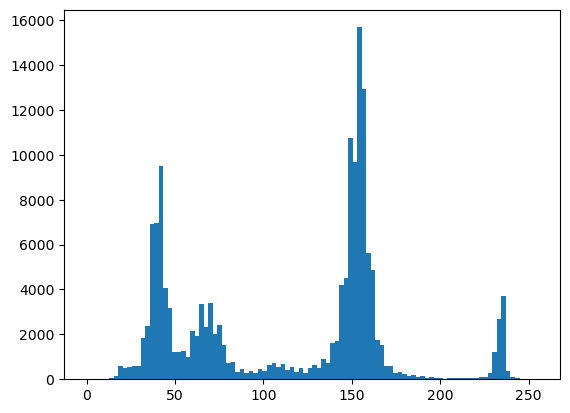

In [30]:
denoise_ubyte = img_as_ubyte(denoise) # 画像を8ビット符号なし整数形式に変換、0-255にスケーリングされる
plt.hist(denoise_ubyte.flat, bins =100, range = (0, 255)) # .flatは2次元配列を1次元にする

denoise_ubyteのヒストグラムは50と150付近にピークがあるので、これらの前後のピクセル値で4つの領域にわける（画像の4値化）

In [31]:
# ヒストグラムのピークを参考に、ピクセル値でセグメントを分ける
# True or Falseのブールインデックスが入った2次元配列になる
segm1 = (denoise_ubyte <= 55)
segm2 = (denoise_ubyte > 55) & (denoise_ubyte <= 110)
segm3 = (denoise_ubyte > 110) & (denoise_ubyte <= 210)
segm4 = (denoise_ubyte > 210)

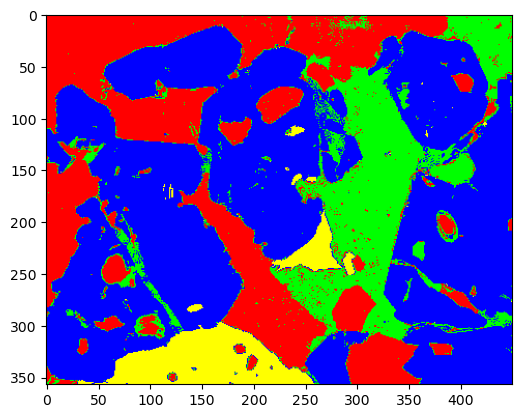

In [32]:
# denoise_ubyteと同じ大きさの空のndarrayを作成、RGB画像にするので3次元目のサイズは3
all_segments = np.zeros((denoise_ubyte.shape[0], denoise_ubyte.shape[1], 3))
# Numpy配列のboolean indexingにより、各セグメントを色分け cf. https://hydrocul.github.io/wiki/numpy/ndarray-ref-boolean.html
all_segments[segm1] = (1,0,0) # segm1が3次元配列だとエラーになる
all_segments[segm2] = (0,1,0)
all_segments[segm3] = (0,0,1)
all_segments[segm4] = (1,1,0)
plt.imshow(all_segments)

In [33]:
# 細かなノイズがあるのでopeningまたはclosing操作での除去を試みる
from scipy import ndimage as nd
segm1_opened = nd.binary_opening(segm1, np.ones((3,3)))
segm1_closed = nd.binary_closing(segm1_opened, np.ones((3,3)))
segm2_opened = nd.binary_opening(segm2, np.ones((3,3)))
segm2_closed = nd.binary_closing(segm2_opened, np.ones((3,3)))
segm3_opened = nd.binary_opening(segm3, np.ones((3,3)))
segm3_closed = nd.binary_closing(segm3_opened, np.ones((3,3)))
segm4_opened = nd.binary_opening(segm4, np.ones((3,3)))
segm4_closed = nd.binary_closing(segm4_opened, np.ones((3,3)))

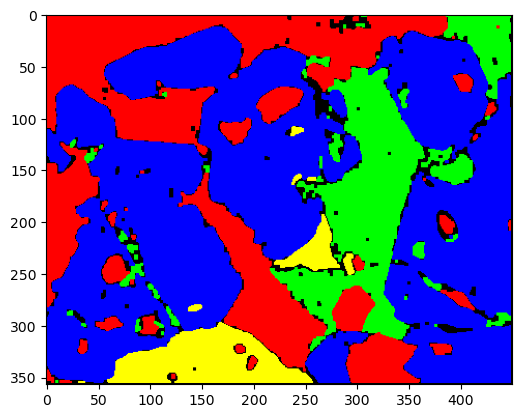

In [34]:
# closingの方が良い画像が得られたのであらためて色分けした画像を作る
all_segments_cleaned = np.zeros((denoise_ubyte.shape[0], denoise_ubyte.shape[1], 3))
all_segments_cleaned[segm1_closed] = (1,0,0)
all_segments_cleaned[segm2_closed] = (0,1,0)
all_segments_cleaned[segm3_closed] = (0,0,1)
all_segments_cleaned[segm4_closed] = (1,1,0)
plt.imshow(all_segments_cleaned)

### Multi-Otsu  
Histogram-based multi segmentationの閾値をOtsu法で計算する。  
通常のOtsuは1つの閾値を計算するが、Multi-Otsuでは指定した数の領域に分割できるよう、複数の閾値を算出

In [38]:
from skimage import data, io, img_as_ubyte, exposure
from skimage.filters import threshold_multiotsu

<class 'numpy.ndarray'>
(69264,)


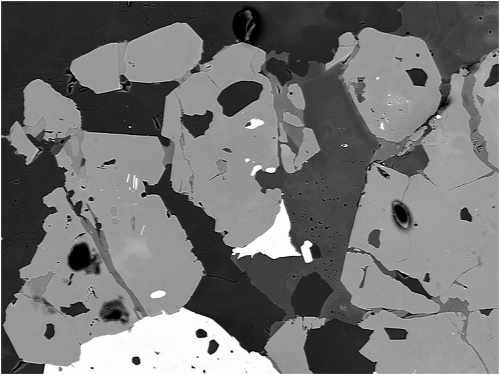

In [35]:
img = img_as_ubyte(io.imread("images/BSE_Image.jpg", as_gray= True))
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2)) # 0.5倍に縮小
show(img)

(array([1.1620e+03, 2.1400e+02, 1.3600e+02, 2.1700e+02, 1.6600e+02,
        2.3100e+02, 1.5500e+02, 3.4400e+02, 2.5900e+02, 5.0200e+02,
        8.0900e+02, 9.6900e+02, 3.7180e+03, 7.0840e+03, 1.6204e+04,
        7.9390e+03, 5.0930e+03, 1.2960e+03, 1.1750e+03, 6.4600e+02,
        9.6100e+02, 9.9800e+02, 8.1500e+02, 2.6340e+03, 2.6780e+03,
        4.1810e+03, 2.4220e+03, 4.5010e+03, 2.3320e+03, 2.5430e+03,
        1.5400e+03, 5.7500e+02, 6.7200e+02, 3.8600e+02, 5.2400e+02,
        3.0900e+02, 4.7500e+02, 3.0400e+02, 4.4700e+02, 3.4700e+02,
        7.1400e+02, 9.5400e+02, 7.4700e+02, 1.1380e+03, 6.3400e+02,
        6.7900e+02, 3.6200e+02, 4.6600e+02, 3.2900e+02, 5.3900e+02,
        6.4300e+02, 4.9700e+02, 7.2100e+02, 4.7900e+02, 8.3000e+02,
        6.9200e+02, 1.6890e+03, 2.6610e+03, 1.2769e+04, 1.5304e+04,
        2.4846e+04, 1.6325e+04, 4.7200e+03, 2.8280e+03, 1.1820e+03,
        1.3200e+03, 7.7200e+02, 7.2800e+02, 3.4900e+02, 3.1800e+02,
        2.5000e+02, 1.5400e+02, 1.9800e+02, 8.40

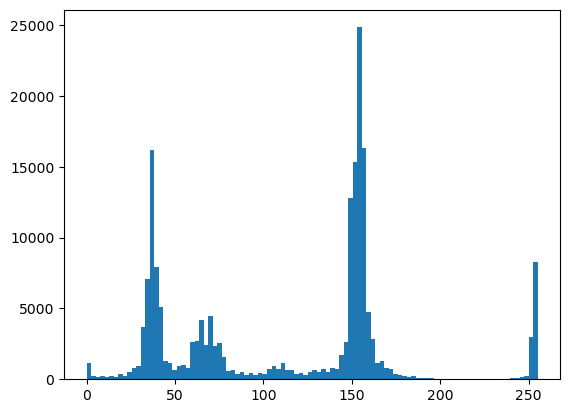

In [36]:
plt.hist(img.flat, bins =100, range = (0, 255)) # .flatは2次元配列を1次元にする

In [39]:
thresholds = threshold_multiotsu(img, classes= 5) # 画像を5つの領域に分割する、4つのthresholdsが計算される
print(thresholds)

[ 52  90 133 202]


int64


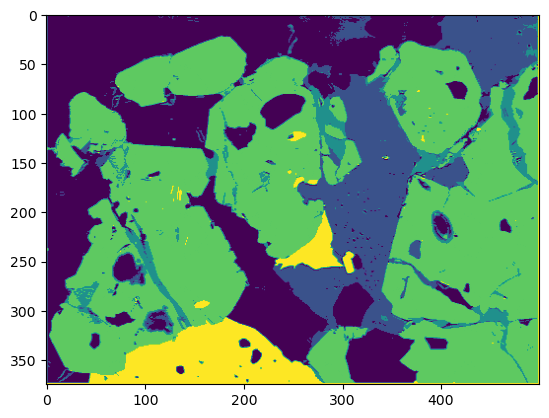

In [40]:
# 各セグメントを分割する、上述とは別の方法
# numpy.digitizeを使用
regions = np.digitize(img, bins = thresholds) # 各ピクセルには0, 1, 2, 3, 4のいずれかの値が入る
print(regions.dtype)
plt.imshow(regions)

In [41]:
output = img_as_ubyte(regions)
output.dtype

/Applications/anaconda3/lib/python3.9/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 4 fits in uint8
  return _convert(image, np.uint8, force_copy)


dtype('uint8')

In [ ]:
# コントラストストレッチしてからunit8に変換する場合
# output = img_as_ubyte(exposure.rescale_intensity(regions))